# **Homework 2 | AB Testing**

## **Libraries**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from Bandit import Bandit
import warnings

In [4]:
warnings.filterwarnings("ignore")

## **Parameters**

In [5]:
num_trials = 20000
bandit_rewards_list = [1,2,3,4]

## **Classes**

In [8]:
class EpsilonGreedyBandit(Bandit):
    """
    EpsilonGreedyBandit class models an epsilon-greedy bandit with the following attributes and methods.

    Attributes:
        reward (float): The true reward of the bandit.

    Methods:
        pull(): Pulls a value from the bandit.
        update(x: float): Updates the estimated reward of the bandit.
        plot1(): Plots the learning process of the bandits.
        experiment(bandit_rewards: list, num_trials: int, path_to_save: str, to_save: bool): Runs the experiment with given bandits, the number of trials, and an option to save the results.
        report(path_to_save: str, to_save: bool): Generates and prints a report of the experiment.
        create_data(): Sets up the dataframe for data storage.
        update_epsilon(): Dynamically updates epsilon with a decay rate of 1/t.

    """
    def __init__(self, reward):
        """
        Initializes a new instance of the EpsilonGreedyBandit class with the following parameter:

        Args:
            reward (float): The true reward of the bandit.

        """
        self.reward = reward  # The true reward
        self.reward_estimate = 0.  # Estimated reward
        self.N = 0  # Iteration count
        self.learning_process = []  # Learning process history
        self.bandits = None  # List of bandits
        self.epsilon = 1  # Initial epsilon value

    def pull(self):
        """
        Pulls a value from the bandit based on its true reward. The value is sampled from a normal distribution with a mean equal to the true bandit reward and a standard deviation of 1.

        """
        return np.random.normal(self.reward, 1)  # Sample a reward from a normal distribution

    def update(self, x):
        """
        Updates the estimated reward of the bandit based on a newly pulled value.

        Args:
            x (float): The newly pulled value used to update the estimated reward.

        """
        self.N += 1  # Increment the iteration count
        self.reward_estimate = ((self.N - 1) * self.reward_estimate + x) / self.N  # Update the reward estimate
        self.learning_process.append(self.reward_estimate)  # Append the updated value to the reward history

    def __repr__(self):
        return f'A bandit with a true reward of {self.reward} and an estimated reward of {self.reward_estimate}'

    def plot1(self):
        """
        Plots the learning curves after the experiment for all existing bandits. It creates a subplot for each bandit's learning curve.

        """
        if self.bandits is None:  # Raise an exception if no experiment has been conducted
            raise Exception('Run the experiment first')
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Create subplots
        plt.suptitle('Learning Curves of All 4 Bandits', size=15)  # Add a title for all subplots
        for index, bandit in enumerate(self.bandits):  # Plot the results for each bandit
            x_index = 1 if index >= 2 else 0
            y_index = index % 2
            axs[x_index, y_index].plot(bandit.learning_process)
            axs[x_index, y_index].set_title(f'True reward: {bandit.reward}')
        plt.show()

    def experiment(self, bandit_rewards, num_trials, path_to_save='', to_save=False):
        """
        Runs an experiment with the given bandit rewards and the number of trials.

        Args:
            bandit_rewards (list): List of true rewards for bandits.
            num_trials (int): The number of iterations for the experiment.
            path_to_save (str): The path for saving the results.
            to_save (bool): Determines whether to save the results.

        """
        if to_save:  # If saving is required, set up the dataframe
            self.create_data()
        self.bandits = [EpsilonGreedyBandit(reward) for reward in bandit_rewards]  # Initialize bandit objects in a list
        self.rewards = np.zeros(num_trials)  # Create a rewards list
        self.regret = []  # Regret list
        for i in range(num_trials):  # Run the iterations
            if np.random.random() < self.epsilon:  # Choose a random bandit if epsilon is high enough
                index = np.random.randint(len(self.bandits))
            else:
                index = np.argmax([b.reward_estimate for b in self.bandits])  # Choose the optimal bandit if epsilon is small
            selected_bandit = self.bandits[index]  # Get the selected bandit
            x = selected_bandit.pull()  # Pull a value from the selected bandit
            if to_save:  # If saving is enabled, add the pulled value to the data
                new_row = {'Bandit': index, 'Reward': x, 'Algorithm': selected_bandit.__class__.__name__}
                self.data = self.data.append(new_row, ignore_index=True)
            self.rewards[i] = x  # Add the result to the rewards array
            self.regret.append(selected_bandit.reward - x)  # Calculate and record the regret
            selected_bandit.update(x)  # Update the estimated reward for the bandit
            self.update_epsilon(i, num_trials)  # Update epsilon
        self.report(path_to_save, to_save)  # Generate and print a report
        return self.rewards

    def report(self, path_to_save, to_save=False):
        """
        Generates a report of the experiment and prints it.

        Args:
            path_to_save (str): The path for saving the results of the experiment.
            to_save (bool): Determines whether to save the results.

        """
        print(' ' * 45 + '\033[1m' + 'Report' + '\033[0m')
        if self.bandits is None:  # Raise an exception if no experiment has been conducted
            raise Exception('Run the experiment first')

        # Part 1 - Plot learning curves
        print('\n-= Part 1 =-')
        self.plot1()

        # Part 2 - Plot cumulative rewards
        print('\n-= Part 2 =-')
        cumulative_rewards = np.cumsum(self.rewards)
        plt.plot(cumulative_rewards)
        plt.title('Plot of Cumulative Rewards\n', size=15)
        plt.show()

        # Part 3 - Save data if requested
        if to_save:
            self.data.to_csv(path_to_save, index=False)

        # Part 4 - Print cumulative reward
        cumulative_reward = cumulative_rewards[-1]
        print(f'The total reward for the experiment is {cumulative_reward}')
        print(f'The cumulative reward over the experiment is {cumulative_rewards}')

        # Part 5 - Print cumulative regret
        cumulative_regrets = np.cumsum(self.regret)
        cumulative_regret = cumulative_regrets[-1]
        print(f'\nThe total regret for the experiment is {cumulative_regret}')
        print(f'The cumulative regret over the experiment is {cumulative_regrets}')

    def create_data(self):
        """
        Initializes the dataset for storing data.

        """
        self.data = pd.DataFrame(columns=['Bandit', 'Reward', 'Algorithm'])  # Create a DataFrame for data storage
        print('The data storage DataFrame is set up.')

    def update_epsilon(self, current_trial, num_trials):
        """
        Dynamically updates the epsilon based on the current trial and the overall number of trials.

        Args:
            current_trial: The current trial.
            num_trials: The total number of trials for the experiment.

        """
        self.epsilon = 1 - (current_trial / num_trials)  # Update epsilon with a decay rate of 1/t


The data storage DataFrame is set up.
                                             Report

-= Part 1 =-


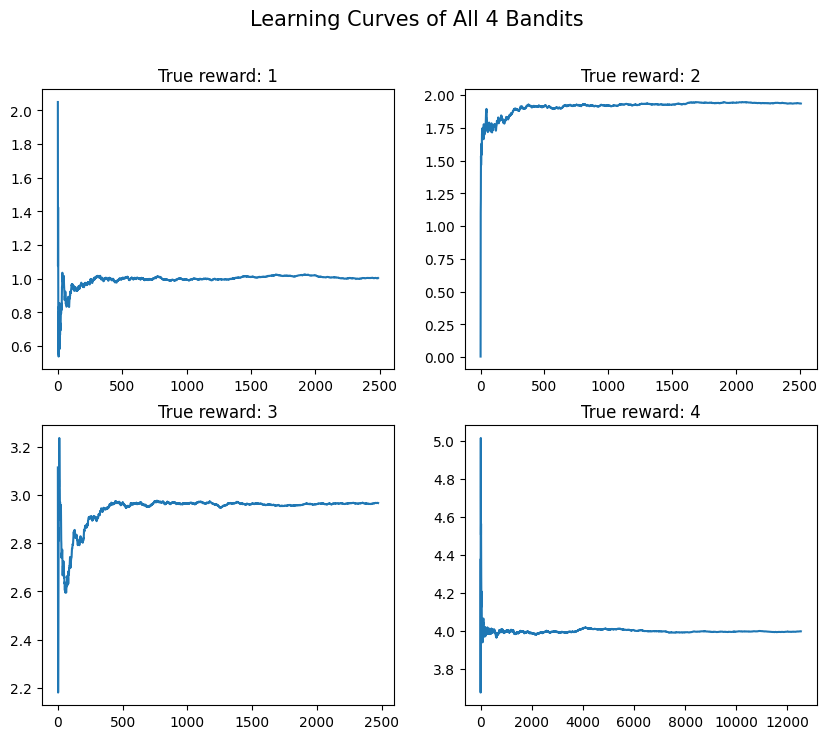


-= Part 2 =-


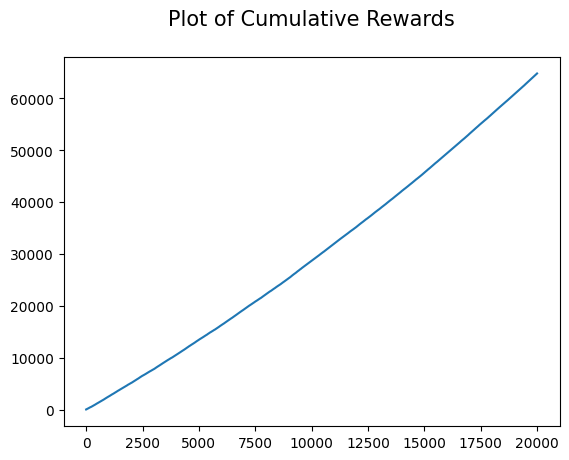

The total reward for the experiment is 64788.258201960016
The cumulative reward over the experiment is [4.37381455e+00 4.37737655e+00 7.49077844e+00 ... 6.47816669e+04
 6.47846041e+04 6.47882582e+04]

The total regret for the experiment is 254.7417980402256
The cumulative regret over the experiment is [ -0.37381455   1.62262345   1.50922156 ... 253.33307975 254.39586457
 254.74179804]


In [12]:
eps_rewards = EpsilonGreedyBandit(Bandit).experiment(bandit_rewards_list, num_trials, 'EpsilonGreedy.csv', to_save=True)

In [10]:
class Bandit:
    pass  # Define a simple base class for bandits

class ThompsonSamplingBandit(Bandit):
    """
    ThompsonSamplingBandit class represents a bandit using the Thompson Sampling algorithm with the following attributes and methods.

    Attributes:
        reward (float): The true reward of the bandit.

    Methods:
        pull(): Pulls a value from the bandit based on the true reward.
        sample(): Samples a value from the estimated reward.
        update(x: float): Updates the estimated reward of the bandit.
        plot1(): Plots the learning process of the bandits.
        experiment(bandit_rewards: list, num_trials: int, path_to_save: str, to_save: bool): Runs an experiment with given bandits, the number of trials, and an option to save the results.
        report(path_to_save: str, to_save: bool): Generates and prints a report of the experiment.
        create_data(): Sets up a dataframe for data storage.
    """
    def __init__(self, reward):
        """
        Initializes a new instance of the ThompsonSamplingBandit class with the following parameter:

        Args:
            reward (float): The true reward of the bandit.

        """
        self.reward = reward  # The true reward
        self.m = 0  # Estimated reward
        self.lambda_ = 1  # Lambda parameter
        self.tau = 1  # Tau parameter
        self.N = 0  # Iteration count
        self.sum_x = 0  # Cumulative reward
        self.learning_process = []  # Learning process history

    def pull(self):
        """
        Pulls a value from the bandit based on the true reward. The value is sampled from a normal distribution with mean equal to the true bandit reward and standard deviation of 1.

        """
        return np.random.randn() / np.sqrt(self.tau) + self.reward

    def sample(self):
        """
        Samples a value from the bandit based on the estimated reward.
        """
        return np.random.randn() / np.sqrt(self.lambda_) + self.m

    def update(self, x):
        """
        Updates the estimated reward of the bandit based on a newly pulled value.

        Args:
            x (float): The newly pulled value used to update the estimated reward.

        """
        self.lambda_ += self.tau  # Update lambda
        self.sum_x += x  # Update the cumulative sum
        self.m = (self.tau * self.sum_x) / self.lambda_  # Update the reward estimate
        self.learning_process.append(self.m)  # Update the learning process list
        self.N += 1  # Increment the iteration count

    def __repr__(self):
        return f'A bandit with a true reward of {self.reward} and an estimated reward of {self.m}'

    def plot1(self):
        """
        Plots the learning curves after the experiment for all existing bandits. It creates a subplot for each bandit's learning curve.

        """
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        plt.suptitle('Learning Curves of All 4 Bandits', size=15)
        for index, bandit in enumerate(self.bandits):
            x_index = 1 if index >= 2 else 0
            y_index = index % 2
            axs[x_index, y_index].plot(bandit.learning_process)
            axs[x_index, y_index].set_title(f'True reward: {bandit.reward}')
        plt.show()

    def experiment(self, bandit_rewards, num_trials, path_to_save, to_save=False):
        """
        Runs an experiment with the given bandit rewards and the number of trials.

        Args:
            bandit_rewards (list): List of true rewards for bandits.
            num_trials (int): The number of iterations for the experiment.
            path_to_save (str): The path for saving the results.
            to_save (bool): Determines whether to save the results.

        """
        if to_save:  # If saving is required, set up the dataframe
            self.create_data()
        self.bandits = [ThompsonSamplingBandit(reward) for reward in bandit_rewards]  # Initialize bandit objects in a list
        self.rewards = np.zeros(num_trials)  # Create a rewards array
        self.regret = []
        for i in range(num_trials):
            index = np.argmax([b.sample() for b in self.bandits])  # Sample from bandit rewards
            selected_bandit = self.bandits[index]
            x = selected_bandit.pull()
            if to_save:
                new_row = {'Bandit': index, 'Reward': x, 'Algorithm': selected_bandit.__class__.__name__}
                self.data = self.data.append(new_row, ignore_index=True)
            self.rewards[i] = x
            self.regret.append(selected_bandit.reward - x)
            selected_bandit.update(x)
        self.report(path_to_save, to_save)
        return self.rewards

    def report(self, path_to_save, to_save=False):
        """
        Generates a report of the experiment and prints it.

        Args:
            path_to_save (str): The path for saving the results of the experiment.
            to_save (bool): Determines whether to save the results.

        """
        if self.bandits is None:
            raise Exception('Run the experiment first')
        print(' ' * 35 + '\033[1m' + 'Report' + '\033[0m')
        # Part 1
        self.plot1()

        # Part 2
        cumulative_rewards = np.cumsum(self.rewards)
        plt.plot(cumulative_rewards)
        plt.title('Plot of Cumulative Rewards\n', size=15)
        plt.show()

        # Part 3
        if to_save:
            self.data.to_csv(path_to_save, index=False)

        # Part 4
        cumulative_reward = cumulative_rewards[-1]
        print(f'The total reward for the experiment is {cumulative_reward}')
        print(f'The cumulative reward over the experiment is {cumulative_rewards}')

        # Part 5
        cumulative_regrets = np.cumsum(self.regret)
        cumulative_regret = cumulative_regrets[-1]
        print(f'\nThe total regret for the experiment is {cumulative_regret}')
        print(f'The cumulative regret over the experiment is {cumulative_regrets}')

    def create_data(self):
        """
        Initializes the dataset for storing data.

        """
        self.data = pd.DataFrame(columns=['Bandit', 'Reward', 'Algorithm'])
        print('The data storage DataFrame is set up.')


The data storage DataFrame is set up.
                                   Report


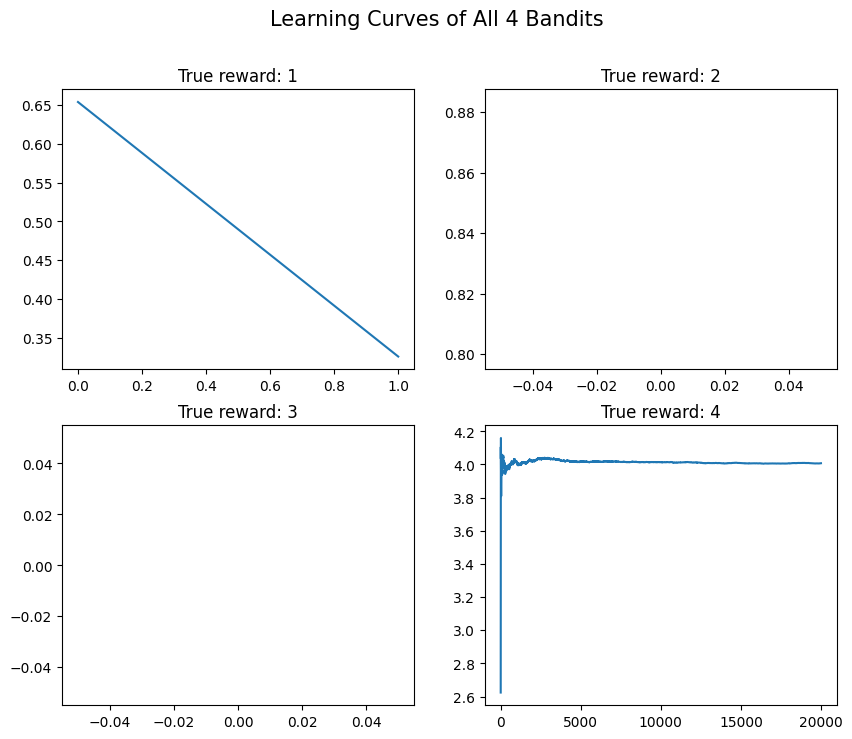

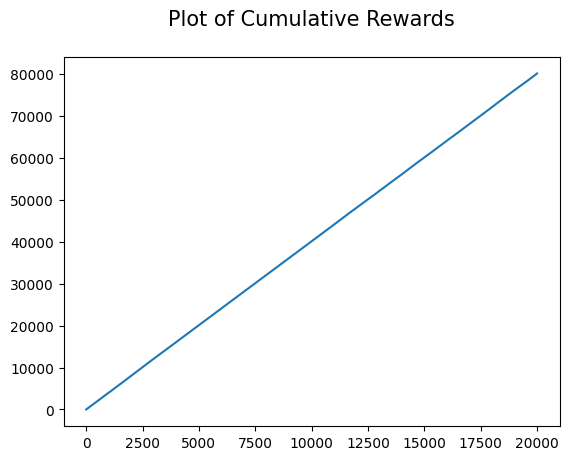

The total reward for the experiment is 80140.54100871061
The cumulative reward over the experiment is [1.30797258e+00 9.76402441e-01 6.22444673e+00 ... 8.01336450e+04
 8.01371790e+04 8.01405410e+04]

The total regret for the experiment is -148.54100871119712
The cumulative regret over the experiment is [  -0.30797258    1.02359756   -0.22444673 ... -149.64502504 -149.17902985
 -148.54100871]


In [13]:
thompson_rewards = ThompsonSamplingBandit(Bandit).experiment(bandit_rewards_list, num_trials, 'ThompsonSampling.csv', to_save=True)

In [16]:
class Bandit:
    pass  # Define a simple base class for bandits

class ThompsonSamplingBandit(Bandit):
    """
    ThompsonSamplingBandit class represents a bandit using the Thompson Sampling algorithm with the following attributes and methods.

    Attributes:
        reward (float): The true reward of the bandit.

    Methods:
        pull(): Pulls a value from the bandit based on the true reward.
        sample(): Samples a value from the estimated reward.
        update(x: float): Updates the estimated reward of the bandit.
        plot1(): Plots the learning process of the bandits.
        experiment(bandit_rewards: list, num_trials: int, path_to_save: str, to_save: bool): Runs an experiment with given bandits, the number of trials, and an option to save the results.
        report(path_to_save: str, to_save: bool): Generates and prints a report of the experiment.
        create_data(): Sets up a dataframe for data storage.
    """
    def __init__(self, reward):
        """
        Initializes a new instance of the ThompsonSamplingBandit class with the following parameter:

        Args:
            reward (float): The true reward of the bandit.

        """
        self.reward = reward  # The true reward
        self.m = 0  # Estimated reward
        self.lambda_ = 1  # Lambda parameter
        self.tau = 1  # Tau parameter
        self.N = 0  # Iteration count
        self.sum_x = 0  # Cumulative reward
        self.learning_process = []  # Learning process history

    def pull(self):
        """
        Pulls a value from the bandit based on the true reward. The value is sampled from a normal distribution with mean equal to the true bandit reward and standard deviation of 1.

        """
        return np.random.randn() / np.sqrt(self.tau) + self.reward

    def sample(self):
        """
        Samples a value from the bandit based on the estimated reward.
        """
        return np.random.randn() / np.sqrt(self.lambda_) + self.m

    def update(self, x):
        """
        Updates the estimated reward of the bandit based on a newly pulled value.

        Args:
            x (float): The newly pulled value used to update the estimated reward.

        """
        self.lambda_ += self.tau  # Update lambda
        self.sum_x += x  # Update the cumulative sum
        self.m = (self.tau * self.sum_x) / self.lambda_  # Update the reward estimate
        self.learning_process.append(self.m)  # Update the learning process list
        self.N += 1  # Increment the iteration count

    def __repr__(self):
        return f'A bandit with a true reward of {self.reward} and an estimated reward of {self.m}'

    def plot1(self):
        """
        Plots the learning curves after the experiment for all existing bandits. It creates a subplot for each bandit's learning curve.

        """
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
        plt.suptitle('Learning Curves of All 4 Bandits', size=15)
        for index, bandit in enumerate(self.bandits):
            x_index = 1 if index >= 2 else 0
            y_index = index % 2
            axs[x_index, y_index].plot(bandit.learning_process)
            axs[x_index, y_index].set_title(f'True reward: {bandit.reward}')
        plt.show()

    def experiment(self, bandit_rewards, num_trials, path_to_save, to_save=False):
        """
        Runs an experiment with the given bandit rewards and the number of trials.

        Args:
            bandit_rewards (list): List of true rewards for bandits.
            num_trials (int): The number of iterations for the experiment.
            path_to save (str): The path for saving the results.
            to_save (bool): Determines whether to save the results.

        """
        if to_save:  # If saving is required, set up the dataframe
            self.create_data()
        self.bandits = [ThompsonSamplingBandit(reward) for reward in bandit_rewards]  # Initialize bandit objects in a list
        self.rewards = np.zeros(num_trials)  # Create a rewards array
        self.regret = []
        for i in range(num_trials):
            index = np.argmax([b.sample() for b in self.bandits])  # Sample from bandit rewards
            selected_bandit = self.bandits[index]
            x = selected_bandit.pull()
            if to_save:
                new_row = {'Bandit': index, 'Reward': x, 'Algorithm': selected_bandit.__class__.__name__}
                self.data = self.data.append(new_row, ignore_index=True)
            self.rewards[i] = x
            self.regret.append(selected_bandit.reward - x)
            selected_bandit.update(x)
        self.report(path_to_save, to_save)
        return self.rewards

    def report(self, path_to_save, to_save=False):
        """
        Generates a report of the experiment and prints it.

        Args:
            path_to_save (str): The path for saving the results of the experiment.
            to_save (bool): Determines whether to save the results.

        """
        if self.bandits is None:
            raise Exception('Run the experiment first')
        print(' ' * 35 + '\033[1m' + 'Report' + '\033[0m')
        # Part 1
        self.plot1()

        # Part 2
        cumulative_rewards = np.cumsum(self.rewards)
        plt.plot(cumulative_rewards)
        plt.title('Plot of Cumulative Rewards\n', size=15)
        plt.show()

        # Part 3
        if to_save:
            self.data.to_csv(path_to_save, index=False)

        # Part 4
        cumulative_reward = cumulative_rewards[-1]
        print(f'The total reward for the experiment is {cumulative_reward}')
        print(f'The cumulative reward over the experiment is {cumulative_rewards}')

        # Part 5
        cumulative_regrets = np.cumsum(self.regret)
        cumulative_regret = cumulative_regrets[-1]
        print(f'\The total regret for the experiment is {cumulative_regret}')
        print(f'The cumulative regret over the experiment is {cumulative_regrets}')

    def create_data(self):
        """
        Initializes the dataset for storing data.

        """
        self.data = pd.DataFrame(columns=['Bandit', 'Reward', 'Algorithm'])
        print('The data storage DataFrame is set up.')


The data storage DataFrame is set up.
                                   Report


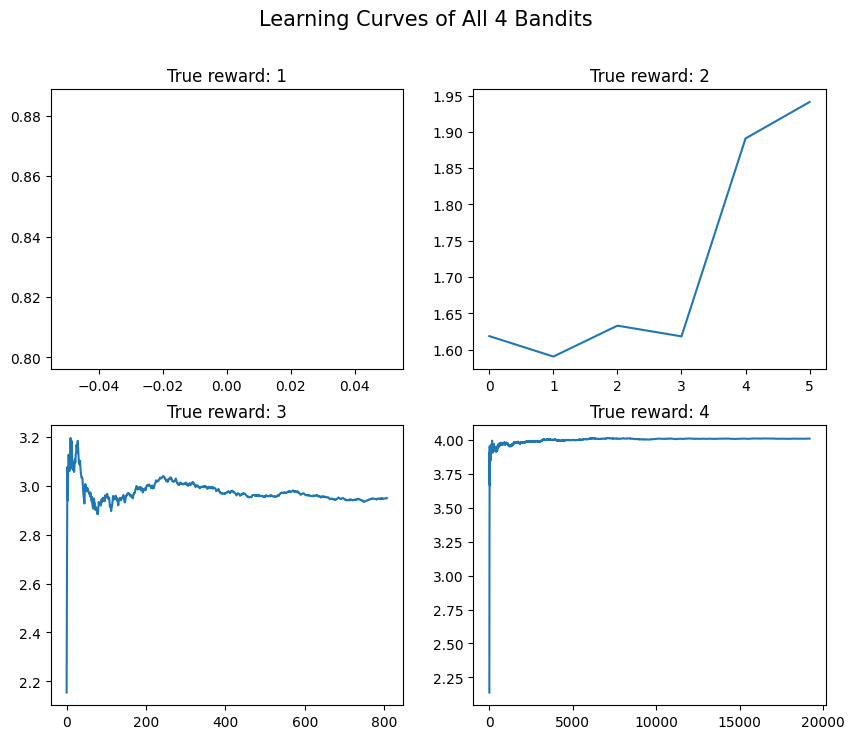

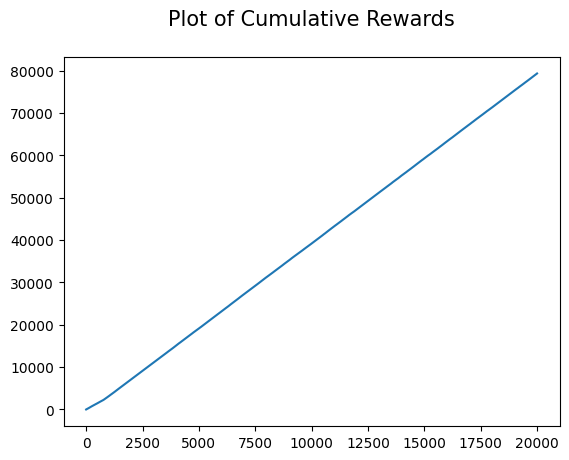

The total reward for the experiment is 79326.60058651636
The cumulative reward over the experiment is [4.30801400e+00 8.08949057e+00 1.23084155e+01 ... 7.93176782e+04
 7.93233885e+04 7.93266006e+04]
\The total regret for the experiment is -149.60058651659682
The cumulative regret over the experiment is [  -1.308014     -2.08949057   -3.30841546 ... -148.67818293 -150.3884664
 -149.60058652]


In [17]:
thompson_rewards = ThompsonSamplingBandit(Bandit).experiment(bandit_rewards_list, num_trials, 'ThompsonSampling.csv', to_save=True)

In [18]:
def compare_epsilon_thompson_rewards(epsilon_rewards, thompson_rewards, num_trials):
    """
    A function for visualizing and comparing the rewards obtained using Epsilon-Greedy and Thompson Sampling algorithms.

    Args:
        epsilon_rewards (list): Rewards obtained using the Epsilon-Greedy algorithm.
        thompson_rewards (list): Rewards obtained using the Thompson Sampling algorithm.
        num_trials (int): The total number of trials or iterations.
    """
    plt.plot(np.arange(num_trials), np.cumsum(epsilon_rewards), label='Epsilon-Greedy')
    plt.plot(np.arange(num_trials), np.cumsum(thompson_rewards), label='Thompson Sampling')
    plt.xlabel('Number of Trials')
    plt.ylabel('Cumulative Estimated Reward')
    plt.title('Comparison of Epsilon-Greedy and Thompson Sampling')
    plt.legend()
    plt.show()


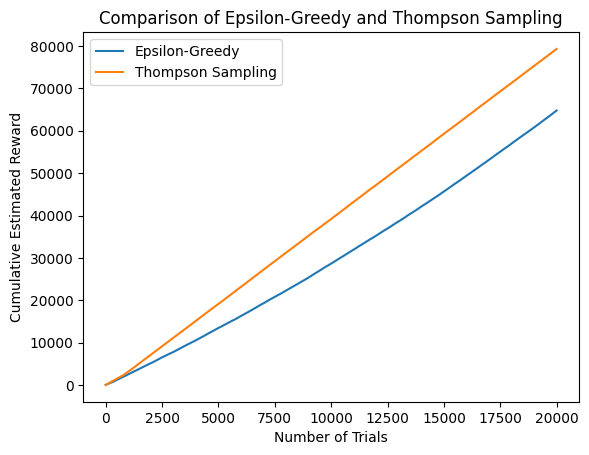

In [20]:
compare_epsilon_thompson_rewards(eps_rewards, thompson_rewards, num_trials)

## **Report**

To sum it up, Thompson Sampling is a probabilistic algorithm that adapts its exploration strategy according to the rewards it observes. In contrast, Epsilon-Greedy is a deterministic algorithm that maintains a fixed epsilon value (or adjusts it) to balance exploration and exploitation. Thompson Sampling is generally regarded as a more advanced approach and can perform better in situations with uncertainty, while Epsilon-Greedy is simpler and more straightforward to implement but may need fine-tuning of the epsilon value for optimal results.

In our experiment, it's evident that Thompson Sampling consistently achieves higher estimated rewards throughout the entire process.